In [1]:
import LMRt
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import mquantiles
from tqdm import tqdm
import pickle
import os

from matplotlib import gridspec                                                           
from matplotlib.colors import BoundaryNorm, Normalize                                     
from matplotlib.ticker import MaxNLocator, ScalarFormatter, FormatStrFormatter            
import cartopy.crs as ccrs                                                                
import cartopy.feature as cfeature                                                        
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter                      
from matplotlib import cm
from cartopy import util as cutil

from statsmodels.tsa import stattools as st

In [2]:
# load precalculated correlation data
inst_tag = 'BerkeleyEarth'
corr = {}
inst_lat = {}
inst_lon = {}
for ptype in ['trw', 'mxd']:
    exp_tag = f'pages2k.tree.{ptype}'
    with open(f'../data/precalculated_corr/corr_{inst_tag}_{exp_tag}.pkl', 'rb') as f:
        corr[ptype], ce, inst_lat[ptype], inst_lon[ptype] = pickle.load(f)
        
corr_mean = {}
for ptype in ['trw', 'mxd']:
    _, nh_mean, _ = LMRt.utils.global_hemispheric_means(corr[ptype], inst_lat[ptype])
    corr_mean[ptype] = nh_mean[0]

In [3]:
# load proxy locations
dirpath = '../data/lmr_proxy_db'
db_proxies_filename = 'LMRdb_v1.1.0_Proxies.df.pckl'
db_metadata_filename = 'LMRdb_v1.1.0_Metadata.df.pckl'
db_proxies_filepath = os.path.join(dirpath, db_proxies_filename)
db_metadata_filepath = os.path.join(dirpath, db_metadata_filename)

site_lats = {}
site_lons = {}
site_color = {}
site_marker = {}
site_markersize = {}

ptypes_dict = {
    'trw': 'Tree Rings_WidthPages2',
    'mxd': 'Tree Rings_WoodDensity',
}

p = LMRt.visual.PAGES2k()
for ptype in ['trw', 'mxd']:
    job = LMRt.ReconJob()
    
    job.cfg.proxies.LMRdb.proxy_order = [ptypes_dict[ptype]]
    job.cfg.proxies.proxy_frac = 1
    
    job.load_proxies(db_proxies_filepath, db_metadata_filepath,
                     verbose=False, print_assim_proxy_count=False)
    
    site_lats[ptype] = []
    site_lons[ptype] = []
    for pobj in job.proxy_manager.sites_assim_proxy_objs:
        if pobj.lat > 0:
            site_lats[ptype].append(pobj.lat)
            site_lons[ptype].append(pobj.lon)
        
    site_color[ptype] = p.colors_dict[ptypes_dict[ptype]]
    site_marker[ptype] = p.markers_dict[ptypes_dict[ptype]]
    site_markersize[ptype] = 50

pid=6757 >>> job.cfg created


Loading proxy: 100%|██████████| 347/347 [00:00<00:00, 394.16it/s]


pid=6757 >>> job.proxy_manager created
pid=6757 >>> job.cfg created


Loading proxy: 100%|██████████| 59/59 [00:00<00:00, 404.16it/s]

pid=6757 >>> job.proxy_manager created


In [4]:
# collect seasonality information

precalib_savepath = '../data/psm_calibration/calib_OLS_GISTEMP_GPCC_pages2k.tree.trw.pkl'
calib_data_trw = pd.read_pickle(precalib_savepath)

precalib_savepath = '../data/psm_calibration/calib_OLS_GISTEMP_pages2k.tree.mxd.pkl'
calib_data_mxd = pd.read_pickle(precalib_savepath)

start_month = {}
end_month = {}
n = {}
n['trw'] = 0
n['mxd'] = 0
type_str = {
    'Tree Rings_WidthPages2': 'trw',
    'Tree Rings_WoodDensity': 'mxd',
}
for k, v in calib_data_trw.items():
    ptype_lmr, pid = k
    season_tag, _ = v['Seasonality']
    avgMonths = list(int(m) for m in season_tag.split('_'))
    
    abs_start_month = np.mod(np.abs(avgMonths[0]), 12)
    if abs_start_month == 0:
        abs_start_month = 12
        
    abs_end_month = np.mod(np.abs(avgMonths[-1]), 12)
    if abs_end_month == 0:
        abs_end_month = 12
    
    if ptype_lmr in type_str.keys():
        ptype = type_str[ptype_lmr]
    else:
        ptype = ptype_lmr
    
    if v['lat'] > 0:
        if ptype in n.keys():
            n[ptype] += 1
        
        if ptype not in start_month.keys():
            start_month[ptype] = []
        else:
            start_month[ptype].append(abs_start_month)
            
        if ptype not in end_month.keys():
            end_month[ptype] = []
        else:
            end_month[ptype].append(abs_end_month)
            
for k, v in calib_data_mxd.items():
    ptype_lmr, pid = k
    season_tag, _ = v['Seasonality']
    avgMonths = list(int(m) for m in season_tag.split('_'))
    
    abs_start_month = np.mod(np.abs(avgMonths[0]), 12)
    if abs_start_month == 0:
        abs_start_month = 12
        
    abs_end_month = np.mod(np.abs(avgMonths[-1]), 12)
    if abs_end_month == 0:
        abs_end_month = 12
    
    if ptype_lmr in type_str.keys():
        ptype = type_str[ptype_lmr]
    else:
        ptype = ptype_lmr
    
    if v['lat'] > 0 and ptype=='mxd':
        if ptype in n.keys():
            n[ptype] += 1
        
        if ptype not in start_month.keys():
            start_month[ptype] = []
        else:
            start_month[ptype].append(abs_start_month)
            
        if ptype not in end_month.keys():
            end_month[ptype] = []
        else:
            end_month[ptype].append(abs_end_month)

In [5]:
# calculate pacf

pacf_dict = {}
pacf_dict['trw'] = []
pacf_dict['mxd'] = []
type_dict = {
    'Tree Rings_WidthPages2': 'trw',
    'Tree Rings_WoodDensity': 'mxd',
}

job = LMRt.ReconJob()
job.cfg.proxies.proxy_frac = 1
job.cfg.proxies.LMRdb.proxy_order = ['Tree Rings_WidthPages2', 'Tree Rings_WoodDensity']
job.load_proxies(db_proxies_filepath, db_metadata_filepath,
                 print_proxy_type_list=True, verbose=False)

for pobj in tqdm(job.proxy_manager.all_proxies):
    if pobj.lat > 0:
        ye =  pobj.values
        pacf = st.pacf(ye, nlags=10)[1:]
        pacf_dict[type_dict[pobj.type]].append(pacf)

pid=6757 >>> job.cfg created


 27%|██▋       | 111/406 [00:00<00:00, 1104.59it/s]

pid=6757 >>> job.proxy_manager created

Proxy types
--------------
                       Tree Rings_WidthPages2:  347
                       Tree Rings_WoodDensity:   59
                                        TOTAL:  406


100%|██████████| 406/406 [00:00<00:00, 986.96it/s] 


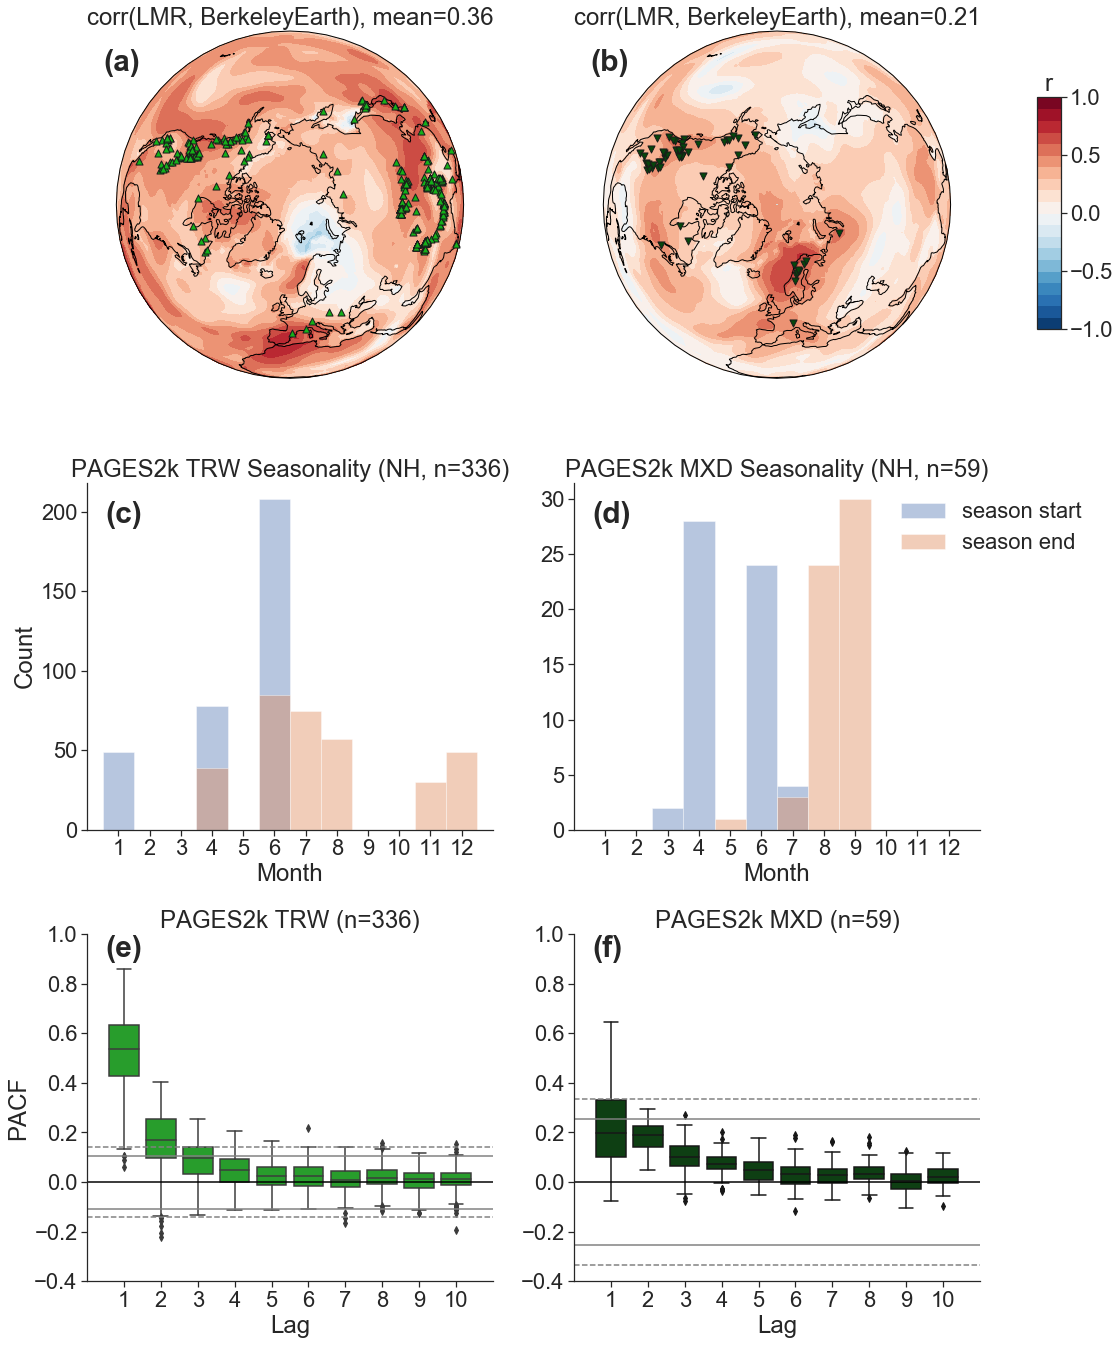

In [6]:
# plot Fig. 2

sns.set(style='ticks', font_scale=2)
fig = plt.figure(figsize=[16, 23])
gs = gridspec.GridSpec(3, 2)                                                   
gs.update(wspace=0.2, hspace=0.3)
                                                                                  
projection = 'Orthographic'
projection = LMRt.visual.CartopySettings.projection_dict[projection](central_longitude=0.0, central_latitude=90)

land_color=sns.xkcd_rgb['light grey']
ocean_color=sns.xkcd_rgb['light grey']

ax = {}
gs_dict = {
    'trw': gs[0, 0],
    'mxd': gs[0, 1],
}
title_dict = {
    'trw': f'corr(LMR, BerkeleyEarth), mean={corr_mean["trw"]:.2f}',
    'mxd': f'corr(LMR, BerkeleyEarth), mean={corr_mean["mxd"]:.2f}',
}
for ptype in ['trw', 'mxd']:
    ax[ptype] = plt.subplot(gs_dict[ptype], projection=projection)
    field_var_c, lon_c = cutil.add_cyclic_point(corr[ptype], inst_lon[ptype])
    lat_c = inst_lat[ptype]
    ax[ptype].set_global()
    ax[ptype].add_feature(cfeature.LAND, facecolor=land_color, edgecolor=land_color)
    ax[ptype].add_feature(cfeature.OCEAN, facecolor=ocean_color, edgecolor=ocean_color)
    ax[ptype].coastlines()
    ax[ptype].set_title(title_dict[ptype])
                      
    transform=ccrs.PlateCarree()
    cmap = plt.get_cmap('RdBu_r')
    levels = np.linspace(-1, 1, 21)
    clim = [-1, 1]
    im = ax[ptype].contourf(lon_c, lat_c, field_var_c, levels, transform=transform, cmap=cmap)
    im.set_clim(clim)
    
    ax[ptype].scatter(site_lons[ptype], site_lats[ptype], s=site_markersize[ptype],
                      c=site_color[ptype], marker=site_marker[ptype], edgecolor='k', zorder=99, transform=transform)
    
cax = fig.add_axes([0.95, 0.7, 0.02, 0.14])
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.ax.set_title('r')
cbar.set_ticks([-1, -0.5, 0, 0.5, 1])

# Seasonality
gs_dict = {
    'trw': gs[1, 0],
    'mxd': gs[1, 1],
}
title_dict = {
    'trw': f'PAGES2k TRW Seasonality',
    'mxd': f'PAGES2k MXD Seasonality',
}
bins = np.arange(1, 14)-0.5
for ptype in ['trw', 'mxd']:
    ax[f'seasonality_{ptype}'] = plt.subplot(gs_dict[ptype])
    sns.distplot(start_month[ptype], label='season start', bins=bins, kde=False)
    sns.distplot(end_month[ptype], label='season end', bins=bins, kde=False)
    ax[f'seasonality_{ptype}'].spines['right'].set_visible(False)                                                                      
    ax[f'seasonality_{ptype}'].spines['top'].set_visible(False)
    ax[f'seasonality_{ptype}'].set_xlabel('Month')
    if ptype == 'trw':
        ax[f'seasonality_{ptype}'].set_ylabel('Count')
    ax[f'seasonality_{ptype}'].set_title(f'{title_dict[ptype]} (NH, n={n[ptype]})')
    ax[f'seasonality_{ptype}'].set_xlim([0, 13])
    ax[f'seasonality_{ptype}'].set_xticks(list(range(1, 13)))
    
ax[f'seasonality_mxd'].legend(frameon=False, loc='upper right', bbox_to_anchor=[1.3, 1])

# PACF
colors_dict = {
    'trw': sns.xkcd_rgb['green'],
    'mxd': sns.xkcd_rgb['forest green'],
}
gs_dict = {
    'trw': gs[2, 0],
    'mxd': gs[2, 1],
}
title_dict = {
    'trw': 'PAGES2k TRW',
    'mxd': 'PAGES2k MXD',
}

z95 = 1.959963984540054                                                                                                                                                               
z99 = 2.5758293035489004
nlag = 10
for ptype in ['trw', 'mxd']:
    ax[f'PACF_{ptype}'] = plt.subplot(gs_dict[ptype])

    autocorrs = pacf_dict[ptype]
    nrec = len(autocorrs)                                                                                                                                                         
    autocorr_array = np.ndarray((nrec, nlag))                                                                                                                                     
    lags = np.arange(1, nlag+1)                                                                                                                                                   
    for j, autocorr in enumerate(autocorrs):                                                                                                                                      
        autocorr_array[j] = autocorr[:nlag]                                                                                                                                       
                                                                                                                                                                                  
    df = pd.DataFrame(data=autocorr_array, columns=lags)
    sns.boxplot(data=df, color=colors_dict[ptype])                                                                                                                              
    ax[f'PACF_{ptype}'].set_xlim([-1, 10])                                                                                                                                                  
    ax[f'PACF_{ptype}'].set_ylim([-0.4, 1])                                                                                                                                                 
    ax[f'PACF_{ptype}'].spines['right'].set_visible(False)                                                                                                                                  
    ax[f'PACF_{ptype}'].spines['top'].set_visible(False)                                                                                                                                    
    ax[f'PACF_{ptype}'].set_title(f'{title_dict[ptype]} (n={len(df)})')                                                                                                                 
    if ptype == 'trw':
        ax[f'PACF_{ptype}'].set_ylabel('PACF')                                                                                                                                                  
    ax[f'PACF_{ptype}'].set_xlabel('Lag')                                                                                                                                                   
    ax[f'PACF_{ptype}'].axhline(y=z99 / np.sqrt(nrec), linestyle='--', color='grey')                                                                                                        
    ax[f'PACF_{ptype}'].axhline(y=z95 / np.sqrt(nrec), color='grey')                                                                                                                        
    ax[f'PACF_{ptype}'].axhline(y=0.0, color='black')                                                                                                                                       
    ax[f'PACF_{ptype}'].axhline(y=-z95 / np.sqrt(nrec), color='grey')                                                                                                                       
    ax[f'PACF_{ptype}'].axhline(y=-z99 / np.sqrt(nrec), linestyle='--', color='grey')                                                                                                       

LMRt.visual.setlabel(ax['trw'], '(a)', prop={'weight': 'bold', 'size': 30}, bbox_to_anchor=[-0.09, 1])
LMRt.visual.setlabel(ax['mxd'], '(b)', prop={'weight': 'bold', 'size': 30}, bbox_to_anchor=[-0.09, 1])
LMRt.visual.setlabel(ax['seasonality_trw'], '(c)', prop={'weight': 'bold', 'size': 30})
LMRt.visual.setlabel(ax['seasonality_mxd'], '(d)', prop={'weight': 'bold', 'size': 30})
LMRt.visual.setlabel(ax['PACF_trw'], '(e)', prop={'weight': 'bold', 'size': 30}, bbox_to_anchor=[0, 1.05])
LMRt.visual.setlabel(ax['PACF_mxd'], '(f)', prop={'weight': 'bold', 'size': 30}, bbox_to_anchor=[0, 1.05])

fig.savefig('../figs/Fig-2.pdf', bbox_inches='tight')